# Test out the basic conditional VAE
* Also look at how it generates per class, and from sampling

In [70]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from PIL import Image

import torch
# from torch import nn
# from torch.autograd import Variable
from torchvision import transforms


# Nicer way to import the module?
# sys.path.append(str(Path.cwd().parent))

# from utils.loading import load_net
# from utils.data import make_generators_DF
# from utils.train_val import validate_epoch
# from utils.evaluation import evaluate_adv_files_df, get_metrics

from utils.display import read_img_to_np, torch_to_np



# import foolbox
# import json

device = torch.device("cuda:1")
# print(device)
# print(torch.cuda.device_count())
# print(torch.cuda.current_device())

# MODEL_PATH = PATH /'models' / 'cvae'

def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

In [62]:
# Loading Dataloaders, Model, weights <- make function??

# Nicer way to import the module?
sys.path.append(str(Path.cwd().parent))

import model.model as module_arch
import data_loader.data_loaders as module_data

# path to dir where all training results saved
PATH = Path('/media/rene/data/hvae/quarterL2KLD/HVAE quarterL2KLD/1211_025228')
config_loc = PATH / 'config.json'
weight_path = PATH / 'model_best.pth'

config = json.load(open(config_loc))
   
data_loader = get_instance(module_data, 'data_loader', config)['train']
valid_data_loader = get_instance(module_data, 'data_loader', config)['val']
model = get_instance(module_arch, 'arch', config)
checkpoint = torch.load(weight_path)
state_dict = checkpoint['state_dict']
if config['n_gpu'] > 1:
    model = torch.nn.DataParallel(model)
    
model.load_state_dict(state_dict)
model = model.to(device).eval()

In [63]:
for key, v in checkpoint.items():
    print(key)
print(checkpoint['optimizer']['param_groups'][0]['params'])

arch
epoch
logger
state_dict
optimizer
monitor_best
config
[140287956460024, 140287956461752, 140287956389248, 140287815444016, 140287815444088, 140287815444160, 140287815444448, 140287815444520, 140287815444808, 140287815444736, 140287815444880, 140287815445024, 140287815445096, 140287815445168, 140287815445456, 140287815445528, 140287815445816, 140287815445888, 140287815445960, 140287815446032, 140287815446104, 140287815446176, 140287815446392, 140287811424400, 140287811424544, 140287811424688, 140287811424832, 140287811424904, 140287811424328, 140287811425120, 140287811425408, 140287811425480, 140287811425840, 140287811425912, 140287811426272, 140287811426344, 140287811426704, 140287811426920, 140287811427064, 140287811427136, 140287811426848, 140287811427352, 140287811427640, 140287811427712, 140287811428072, 140287811428144, 140287811428288, 140287811371080, 140287811371224, 140287811371296]


In [64]:
def display_results_auto(vae_model, config, num_samples=5, data='mnist', size = 32, label_col_name='class'):
#     with torch.cuda.device(1): # ??? Why the fuck???
    files_dict_loc = config['data_loader']['args']['files_dict_loc']
    with open(files_dict_loc, 'rb') as f:
        files_df = pickle.load(f)['val']
    
    all_labels = files_df[label_col_name].unique()
    num_labels = len(all_labels)
    row_names = []
    col_names = ['Original', "Reconstructed"]

    fig, ax = plt.subplots(num_samples, 2, sharex='col', sharey='row',figsize=(15,15))

    for i, label in enumerate(all_labels[0:num_samples]):
        sample_df = files_df.loc[files_df[label_col_name] == label].sample(n=1)
        img_path = sample_df['path'].iloc[0]
        label = sample_df[label_col_name].iloc[0]
        row_names.append(label)

        if data == 'mnist': # MNIST
            img = read_img_to_np(img_path, bw=True)
            transform = transforms.Compose([
                                            transforms.Resize(size),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.1307,), (0.3081,))])
        elif data == 'cifar': # CIFAR10
            img = read_img_to_np(img_path, bw=False, size=size)
            transform = transforms.Compose([
                                            transforms.Resize(size),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.4914, 0.4822, 0.4465], 
                                                                 [0.2023, 0.1994, 0.2010])])

        tensor_img = transform(Image.open(img_path)).unsqueeze(0).to(device)

        tensor_label = torch.from_numpy(np.array(label)).unsqueeze(0).type(torch.LongTensor).to(device)
        recon_x, mu, logvar = model(tensor_img, tensor_label)

        ax[i, 0].imshow(img)
        ax[i, 1].imshow(torch_to_np(recon_x))
        ax[i, 0].axis('off')
        ax[i, 1].axis('off')

    for curr_ax, col in zip(ax[0], col_names):
        curr_ax.set_title(col)

    for curr_ax, row in zip(ax[:,0], row_names):
        curr_ax.set_ylabel(row, rotation=0, size='large')

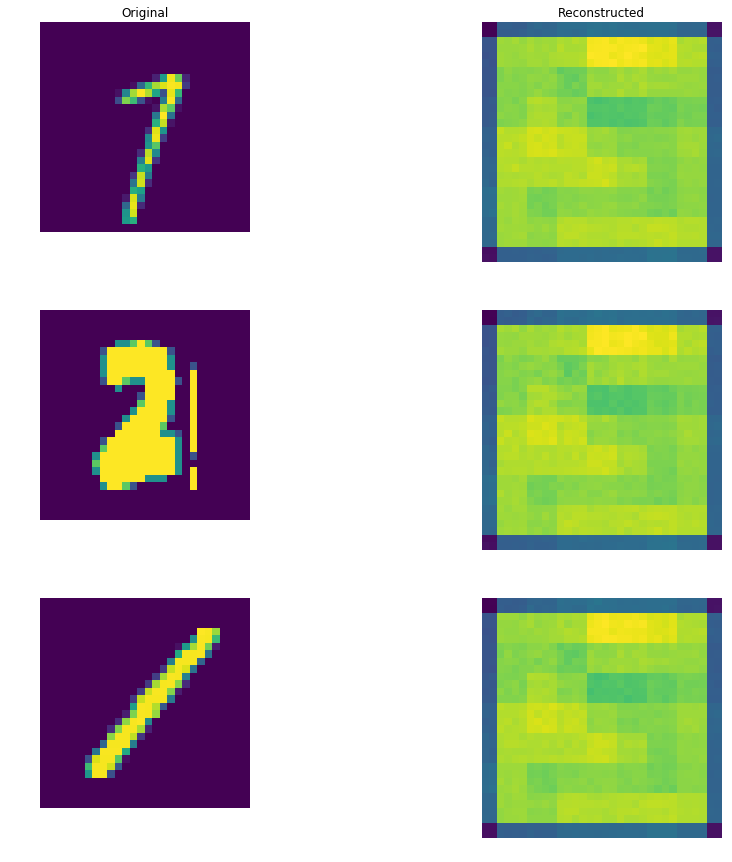

In [65]:
display_results_auto(model, config, num_samples=3)